# Visualization & helper code

In [1]:
%%html
<style>@import url('style.css')</style><script>IPython.OutputArea.prototype._should_scroll = function(){return false}</script>

In [2]:
import os
import subprocess
import sys
import time

import IPython

import matplotlib
import librosa
import numpy as np
import pandas as pd
import sklearn as sk

from tqdm import *

import matplotlib.pyplot as plt
import seaborn as sb

sb.set(style="white")
matplotlib.rcParams['font.family'] = 'PT Sans'

DATA_PATH = '/volatile/dcase17_1/'

In [3]:
train = pd.read_csv(f'{DATA_PATH}/evaluation_setup/fold4_train.txt', sep='\t', names=['file', 'scene'], converters={'file': lambda s: s.replace('audio/', '')})
validation = pd.read_csv(f'{DATA_PATH}/evaluation_setup/fold4_evaluate.txt', sep='\t', names=['file', 'scene'], converters={'file': lambda s: s.replace('audio/', '')})

label_encoder = sk.preprocessing.LabelEncoder()
label_encoder.fit(sorted(pd.unique(train['scene'])))
label_encoder.classes_

array(['beach', 'bus', 'cafe/restaurant', 'car', 'city_center',
       'forest_path', 'grocery_store', 'home', 'library', 'metro_station',
       'office', 'park', 'residential_area', 'train', 'tram'],
      dtype='<U16')

---

### Figure 1
#### Comparison of spectrograms

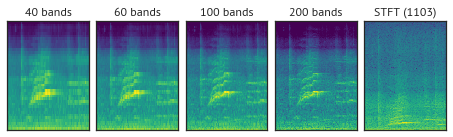

In [4]:
row = list(train.itertuples())[1471]

def plot_spec(ax, bands):
    audio, _ = librosa.core.load(f'{DATA_PATH}/audio/{row.file}', sr=44100, dtype=np.float32, duration=10.0)

    if bands == 'stft':
        spec = np.abs(librosa.stft(audio, n_fft=2205, hop_length=882))
    else:
        spec = librosa.feature.melspectrogram(audio, sr=44100, n_fft=2205, hop_length=882, n_mels=bands, fmax=22050, power=2)
        
    spec = librosa.power_to_db(spec)
    spec = spec[:, 150:300]

    ax.imshow(spec, origin='lower', cmap='viridis', interpolation='none', aspect='equal', extent=(0, 150, 0, 200))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if bands == 'stft':
        ax.set_title(f'STFT (1103)', fontsize=12)
    else:
        ax.set_title(f'{bands} bands', fontsize=12)
        
    ax.autoscale(False)
        
    
f, axes = plt.subplots(1, 5, sharey=False, sharex=False, figsize=(8, 2))

plot_spec(axes[0], 40)
plot_spec(axes[1], 60)
plot_spec(axes[2], 100)
plot_spec(axes[3], 200)
plot_spec(axes[4], 'stft')

f.subplots_adjust(wspace=0.0, hspace=0.0)

plt.savefig('figures/spectrograms.pdf', bbox_inches='tight')

---

### Part of Figure 2
#### Spectrogram input

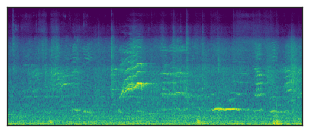

In [5]:
row = list(train.itertuples())[1471]

def plot_spec(ax, bands):
    audio, _ = librosa.core.load(f'{DATA_PATH}/audio/{row.file}', sr=44100, dtype=np.float32, duration=10.0)
    spec = librosa.feature.melspectrogram(audio, sr=44100, n_fft=2205, hop_length=882, n_mels=bands, fmax=22050, power=2)
        
    spec = librosa.power_to_db(spec)
    spec = spec[:, :]

    ax.imshow(spec, origin='lower', cmap='viridis', interpolation='none', aspect='equal', extent=(0, 500, 0, 200))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    ax.autoscale(False)
            
f, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(8, 2))

plot_spec(axes, 200)
plt.tight_layout()

plt.savefig('figures/spectrogram_input.pdf', bbox_inches='tight')

---

#### Hex palettes

In [6]:
palette = sb.cubehelix_palette(8, rot=0.25)
palette.as_hex()

['#efcddf',
 '#deaece',
 '#c791be',
 '#ac76ac',
 '#8d5e99',
 '#6c4880',
 '#4a3463',
 '#29203f']

#000004
#180f3d
#440f76
#721f81
#9e2f7f
#cd4071
#f1605d
#fd9668
#feca8d
#fcfdbf


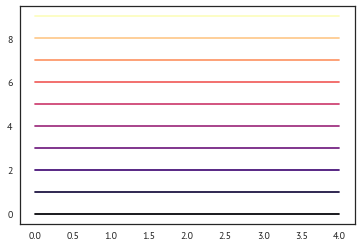

In [7]:
cmap = plt.cm.get_cmap('magma', 10)

for i in range(cmap.N):
    plt.plot(np.arange(0, 5), np.repeat(i, 5), color=cmap(i))
    rgb = cmap(i)[:3]  # RGBA
    print(matplotlib.colors.rgb2hex(rgb))

---

### Figure 3
#### Validation accuracy depending on the number of bands

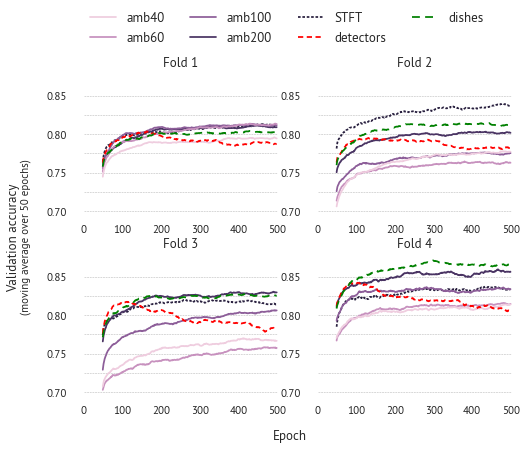

In [8]:
f, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 6))

palette = sb.cubehelix_palette(8, rot=0.25)
palette_2 = sb.cubehelix_palette(8, rot=0.25)

def plot_fold(ax, fold):
    score = {
        40: [0],
        60: [0],
        100: [0],
        200: [0],
        'stft': [0],
        'detectors': [0],
        'dishes': [0],
    }
    
    if os.path.exists(f'results/run_40_{fold}.npz'): score[40] = np.load(f'results/run_40_{fold}.npz')['validation_score_bin']
    if os.path.exists(f'results/run_60_{fold}.npz'): score[60] = np.load(f'results/run_60_{fold}.npz')['validation_score_bin']
    if os.path.exists(f'results/run_100_{fold}.npz'): score[100] = np.load(f'results/run_100_{fold}.npz')['validation_score_bin'] 
    if os.path.exists(f'results/run_200_{fold}.npz'): score[200] = np.load(f'results/run_200_{fold}.npz')['validation_score_bin'] 
    if os.path.exists(f'results/run_stft_{fold}.npz'): score['stft'] = np.load(f'results/run_stft_{fold}.npz')['validation_score_bin']        
    if os.path.exists(f'results/run_detectors_{fold}.npz'): score['detectors'] = np.load(f'results/run_detectors_{fold}.npz')['validation_score_bin']
    if os.path.exists(f'results/run_dishes_{fold}.npz'): score['dishes'] = np.load(f'results/run_dishes_{fold}.npz')['validation_score_bin']

    ma_window = 50
    
    ax.plot(pd.DataFrame(score['stft']).rolling(ma_window).mean(), color=palette[7], dashes=[1.5, 1])
    ax.plot(pd.DataFrame(score[200]).rolling(ma_window).mean(), color=palette[6])
    ax.plot(pd.DataFrame(score[100]).rolling(ma_window).mean(), color=palette[4])
    ax.plot(pd.DataFrame(score[60]).rolling(ma_window).mean(), color=palette[2])
    ax.plot(pd.DataFrame(score[40]).rolling(ma_window).mean(), color=palette[0])
    ax.plot(pd.DataFrame(score['detectors']).rolling(ma_window).mean(), color='red', dashes=[3, 2])
    ax.plot(pd.DataFrame(score['dishes']).rolling(ma_window).mean(), color='green', dashes=[4.5, 3])
        
    ax.set_title(f'Fold {fold}', fontsize=13)
    sb.despine(ax=ax, left=True, bottom=True, offset=50)
    
    for y in np.arange(0.7, 0.85, .025):
        ax.plot([0, 500], [y, y], '--', lw=0.5, color="black", alpha=0.3, zorder=-10)
        
    ax.set_yticks(np.arange(0.7, 0.85, .05))
    ax.set_yticklabels(['{0:.2f}'.format(s) for s in np.arange(0.7, 0.85, .05)], fontsize=11)
    
    ax.set_xticks(np.arange(0, 501, 100))
    ax.set_xticklabels(np.arange(0, 501, 100), fontsize=11)
    
plot_fold(axes[0, 0], 1)
plot_fold(axes[0, 1], 2)
plot_fold(axes[1, 0], 3)
plot_fold(axes[1, 1], 4)

f.subplots_adjust(wspace=0.1, hspace=0.25)

f.text(0.5, 0.03, 'Epoch', ha='center', fontsize=13,)
f.text(0.02, 0.5, 'Validation accuracy', fontsize=13, va='center', ha='center', rotation='vertical')
f.text(0.04, 0.5, '(moving average over 50 epochs)', fontsize=11, va='center', ha='center', rotation='vertical')

axes[0, 0].legend(
    [plt.Line2D((0, 1), (0, 0), color=palette[0]), plt.Line2D((0, 1), (0, 0), color=palette[2]),
    plt.Line2D((0, 1), (0, 0), color=palette[4]), plt.Line2D((0, 1), (0, 0), color=palette[6]),
    plt.Line2D((0, 1), (0, 0), color=palette[7], dashes=[1.5, 1]),
    plt.Line2D((0, 1), (0, 0), color='red', dashes=[3, 2]),
    plt.Line2D((0, 1), (0, 0), color='green', dashes=[4.5, 3])],
    ['amb40', 'amb60', 'amb100', 'amb200', 'STFT', 'detectors', 'dishes'],
    loc='upper center',
    ncol=4,
    fontsize=13,
    bbox_to_anchor=(1.0, 1.5)
)

plt.savefig('figures/validation.pdf', bbox_inches='tight')

---

#### LaTeX table with results

In [9]:
def get_score(run, fold):
    scores = np.load(f'results/run_{run}_{fold}.npz')['validation_score_bin'][-50:]
    return np.mean(scores), np.std(scores)
    
    return (f'{np.round(np.mean(scores) * 100, 1)} ({np.round(np.std(scores) * 100, 1)})')

def print_row(run):
    if isinstance(run, int):
        row = f'amb{run}'
    else:
        row = f'{run}'
    avg = 0.0
    
    for fold in [1, 2, 3, 4]:
        mean, std = get_score(run, fold)
        row += f' & {np.round(mean * 100, 1)} ({np.round(std * 100, 1)})'
        avg += mean
    
    avg /= 4.0
    row += f' & {np.round(avg * 100, 1)} \\\\'
    
    print(row)
    
print_row(40)
print_row(60)
print_row(100)
print_row(200)
print_row('stft')
print_row('detectors')
print_row('dishes')

amb40 & 79.4 (0.5) & 77.7 (0.8) & 76.7 (1.0) & 81.4 (1.0) & 78.8 \\
amb60 & 81.3 (0.6) & 76.3 (1.0) & 75.8 (0.9) & 81.5 (1.0) & 78.7 \\
amb100 & 81.1 (0.6) & 77.5 (0.9) & 80.6 (0.7) & 83.4 (1.3) & 80.7 \\
amb200 & 80.9 (0.8) & 80.2 (0.8) & 83.0 (0.9) & 85.6 (1.3) & 82.4 \\
stft & 81.1 (0.9) & 83.6 (0.8) & 81.4 (0.9) & 83.4 (1.3) & 82.4 \\
detectors & 78.7 (0.9) & 78.1 (1.1) & 78.6 (1.3) & 80.8 (1.4) & 79.1 \\
dishes & 80.3 (0.9) & 81.4 (0.7) & 82.6 (0.6) & 86.6 (1.0) & 82.7 \\


---

####  Visualizing filters

In [10]:
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = ('floatX=float32,'
                              'device=gpu0,'
                              'dnn.conv.algo_bwd_filter=deterministic,'
                              'dnn.conv.algo_bwd_data=deterministic,'
                              'exception_verbosity=high')

import keras
keras.backend.set_image_data_format('channels_first')
from keras import backend as K
from keras.models import Model
from keras.activations import softmax
from keras.layers import Input, concatenate
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense, Dropout, Flatten, Reshape, Lambda, Permute
from keras.callbacks import LearningRateScheduler, Callback
from keras.layers.normalization import BatchNormalization

inputs = Input(shape=(1, 200, 500))

x = Conv2D(100, kernel_size=(200, 50), kernel_initializer='he_uniform')(inputs)
x = BatchNormalization(axis=1)(x)
x = LeakyReLU()(x)
x = Dropout(0.25)(x)

x = Conv2D(100, kernel_size=(1, 1), kernel_initializer='he_uniform')(x)
x = BatchNormalization(axis=1)(x)
x = LeakyReLU()(x)
x = Dropout(0.25)(x)

x = Conv2D(15, kernel_size=(1, 1), kernel_initializer='he_uniform')(x)
x = Lambda(softmax, arguments={'axis': 1}, name='softmax')(x)

x = GlobalAveragePooling2D()(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

model.load_weights('results/run_200_4.h5')

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5105)
/opt/conda/envs/latest/lib/python3.6/site-packages/keras/layers/core.py:629: UserWarning: `output_shape` argument not specified for layer softmax and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 15, 1, 451)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


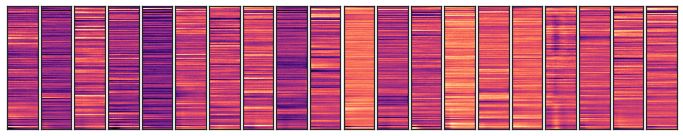

In [11]:
f = plt.figure(figsize=(12, 4))

cmap = 'magma'

n_filters = 20

for i in range(n_filters):    
    ax = plt.subplot2grid((1, n_filters), (0, i))
    ax.imshow(model.layers[1].get_weights()[0][:, :, 0, i], origin='lower', interpolation='none', cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
f.subplots_adjust(wspace=0.1, hspace=0.25)

plt.savefig('figures/conv1_filters.pdf', bbox_inches='tight')

In [12]:
# Based on: https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
# Computes on CPU

def plot_max(scene_idx, show=False):
    loss = K.mean(model.layers[-3].output[:, scene_idx, 0, 0])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input] + [K.learning_phase()], [loss, grads])
    data = np.random.random((1, 1, 200, 500))

    for i in range(10):
        loss_value, grads_value = iterate([data, 1])
        data += grads_value * 1.0
        if show:
            IPython.display.clear_output()
            plt.imshow(data[0, 0, :, :50], origin='lower', cmap='plasma')
            plt.show()
        
    return data

In [13]:
templates = []
for i in tqdm(range(15)):
    templates.append(plot_max(i))

100%|██████████| 15/15 [06:49<00:00, 27.33s/it]


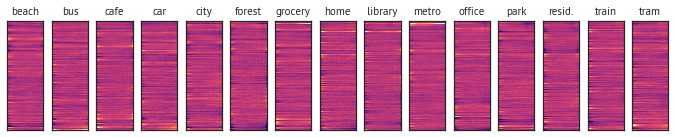

In [14]:
f = plt.figure(figsize=(12, 4))
scale = 50

for i in range(15):
    ax = plt.subplot2grid((2, 15), (0, i))
    template = templates[i][0, 0, :, :50]
    ax.imshow(template, origin='lower', interpolation='none', cmap='magma', extent=(0, 50, 0, 150), vmin=-scale, vmax=scale)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    l = label_encoder.classes_[i]
    l = l.replace('cafe/restaurant', 'cafe')
    l = l.replace('city_center', 'city')
    l = l.replace('forest_path', 'forest')
    l = l.replace('grocery_store', 'grocery')
    l = l.replace('metro_station', 'metro')
    l = l.replace('residential_area', 'resid.')
    
    ax.set_title(l, fontsize=11)

f.subplots_adjust(wspace=0.0, hspace=0.0)

plt.savefig('figures/max_activations.pdf', bbox_inches='tight')

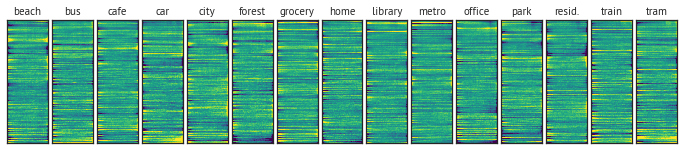

In [15]:
import skimage.exposure

f = plt.figure(figsize=(12, 6))
scale = 20

for i in range(15):
    ax = plt.subplot2grid((2, 15), (0, i))
    template = templates[i][0, 0, :, :50]
    template = skimage.exposure.rescale_intensity(template, in_range=(-scale, scale), out_range=(0.0, 1.0))
    template = skimage.exposure.adjust_gamma(template, 0.8)
    ax.imshow(template, origin='lower', interpolation='none', cmap='viridis', extent=(0, 50, 0, 150), vmin=0.0, vmax=1.0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    l = label_encoder.classes_[i]
    l = l.replace('cafe/restaurant', 'cafe')
    l = l.replace('city_center', 'city')
    l = l.replace('forest_path', 'forest')
    l = l.replace('grocery_store', 'grocery')
    l = l.replace('metro_station', 'metro')
    l = l.replace('residential_area', 'resid.')
    
    ax.set_title(l, fontsize=11)
    
f.subplots_adjust(wspace=0.1, hspace=0.0)

plt.savefig('figures/max_activations.pdf', bbox_inches='tight')

#### Verify generated templates 

In [16]:
predict = K.function([model.input] + [K.learning_phase()], model.get_layer('softmax').output)
predict([templates[14], 1.])[:, :, 0, 0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]], dtype=float32)

---

## Debugging 

In [17]:
train = pd.read_csv(f'{DATA_PATH}/evaluation_setup/fold1_train.txt', sep='\t', names=['file', 'scene'], converters={'file': lambda s: s.replace('audio/', '')})
validation = pd.read_csv(f'{DATA_PATH}/evaluation_setup/fold1_evaluate.txt', sep='\t', names=['file', 'scene'], converters={'file': lambda s: s.replace('audio/', '')})
label_encoder = sk.preprocessing.LabelEncoder()
label_encoder.fit(sorted(pd.unique(train['scene'])))
label_encoder.classes_

array(['beach', 'bus', 'cafe/restaurant', 'car', 'city_center',
       'forest_path', 'grocery_store', 'home', 'library', 'metro_station',
       'office', 'park', 'residential_area', 'train', 'tram'],
      dtype='<U16')

#### Misshits

In [18]:
miss = pd.read_csv(f'results/miss.txt', sep='\t', names=['file', 'scene_true', 'scene_predicted'], converters={'file': lambda s: s.replace('audio/', '')})
miss['recording'] = miss['file'].apply(lambda s: s[:4])
miss

,file,scene_true,scene_predicted,recording
0,a002_130_140.wav,residential_area,park,a002
1,a002_60_70.wav,residential_area,forest_path,a002
2,a004_0_10.wav,park,residential_area,a004
3,a004_20_30.wav,park,residential_area,a004
4,a004_70_80.wav,park,residential_area,a004
5,a008_10_20.wav,residential_area,park,a008
6,a008_170_180.wav,residential_area,park,a008
7,a008_20_30.wav,residential_area,park,a008
8,a008_40_50.wav,residential_area,park,a008
9,a008_50_60.wav,residential_area,park,a008


#### Preview misclassified examples

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

def plot(idx, recording):
    IPython.display.clear_output(wait=True)
    
    row = list(miss[miss['recording'] == recording].itertuples())[idx]
    audio, _ = librosa.core.load(f'{DATA_PATH}/audio/{row.file}', sr=44100, dtype=np.float32, duration=10.0)
        
    spec = librosa.feature.melspectrogram(audio, sr=44100, n_fft=2205, hop_length=882, n_mels=200, fmax=22050, power=1)
    spec = librosa.amplitude_to_db(spec)

    print(np.mean(spec), np.std(spec))
    
    MEAN = -60.0
    STD = 15.0
     
    spec = (spec - MEAN) / STD * -1.

    plt.figure(figsize=(16, 8))
    plt.imshow(spec, interpolation='none', aspect='equal', extent=(0, 100, 0, 50), origin='lower', vmin=-2, vmax=2, cmap='RdBu')
    # plt.colorbar(orientation='horizontal')
    plt.title(f'True: {row.scene_true}    Predicted: {row.scene_predicted}    File: {row.file}')
    plt.show()

    IPython.display.display(IPython.display.Audio(data=audio, rate=44100, autoplay=True))


interact(plot,
         idx=IntSlider(0, 0, 10, 1, continuous_update=False),
         recording=pd.unique(miss['recording'])
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=10), Dropdown(description='recording', options=('a002', 'a004', 'a008', 'a011', 'a013', 'a024', 'a025', 'a028', 'a035', 'a042', 'a044', 'a055', 'a063', 'a086', 'a087', 'a090', 'a093', 'a108', 'a114', 'a115', 'a117', 'a119', 'a124', 'a125', 'a143', 'a146', 'b002', 'b026', 'b027', 'b043', 'b051', 'b066', 'b070', 'b076'), value='a002'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

---

#### Visually compare different band settings (mix of 25 segments of a given scene)

In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

def plot(MEL, idx, scene):
    IPython.display.clear_output(wait=True)
    
    np.random.seed(1)
    rows = pd.concat([train, validation])
    rows = rows[rows['scene'] == scene]
    
    mix = []
    
    rows = list(rows.iloc[np.random.permutation(len(rows))].itertuples())[idx:idx+25]
    for row in rows:
        audio, _ = librosa.core.load(f'{DATA_PATH}/audio/{row.file}', sr=44100, dtype=np.float32, duration=1.0)
        mix.append(audio)

    mix = np.concatenate(mix)
        
    spec = librosa.feature.melspectrogram(mix, sr=44100, n_fft=2205, hop_length=882, n_mels=MEL, fmax=22050, power=1)
#     spec = librosa.stft(mix, n_fft=512, hop_length=882)
    spec = librosa.amplitude_to_db(spec)

    print(np.mean(spec), np.std(spec))
    
    MEAN = -60.0
    STD = 15.0
    
    spec = (spec - MEAN) / STD * -1.

    plt.figure(figsize=(16, 8))
    plt.imshow(spec, interpolation='none', aspect='equal', extent=(0, 100, 0, 50), origin='lower', vmin=-2, vmax=2, cmap='RdBu')
    # plt.colorbar(orientation='horizontal')
    plt.title(f'{row.scene} : {row.file}')
    plt.show()

    IPython.display.display(IPython.display.Audio(data=mix, rate=44100, autoplay=True))


interact(plot,
         MEL=IntSlider(200, 10, 400, 5, continuous_update=False),
         idx=IntSlider(0, 0, 100, 1, continuous_update=False),
         scene=label_encoder.classes_
)

interactive(children=(IntSlider(value=200, continuous_update=False, description='MEL', max=400, min=10, step=5), IntSlider(value=0, continuous_update=False, description='idx'), Dropdown(description='scene', options=('beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram'), value='beach'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>